##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Multilevel Modeling Primer in TensorFlow Probability

**This example is ported from the PyMC3 example notebook [A Primer on Bayesian Methods for Multilevel Modeling](https://github.com/pymc-devs/pymc3/blob/master/docs/source/notebooks/multilevel_modeling.ipynb)**

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Multilevel_Modeling_Primer.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Multilevel_Modeling_Primer.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>


### Dependencies & Prerequisites

In [0]:
#@title Install { display-mode: "form" }
TF_Installation = 'TF2 Nightly (GPU)' #@param ['TF2 Nightly (GPU)', 'TF2 Stable (GPU)', 'TF1 Nightly (GPU)', 'TF1 Stable (GPU)','System']

if TF_Installation == 'TF2 Nightly (GPU)':
  !pip install -q --upgrade tf-nightly-gpu-2.0-preview
  print('Installation of `tf-nightly-gpu-2.0-preview` complete.')
elif TF_Installation == 'TF2 Stable (GPU)':
  !pip install -q --upgrade tensorflow-gpu==2.0.0-alpha0
  print('Installation of `tensorflow-gpu==2.0.0-alpha0` complete.')
elif TF_Installation == 'TF1 Nightly (GPU)':
  !pip install -q --upgrade tf-nightly-gpu
  print('Installation of `tf-nightly-gpu` complete.')
elif TF_Installation == 'TF1 Stable (GPU)':
  !pip install -q --upgrade tensorflow-gpu
  print('Installation of `tensorflow-gpu` complete.')
elif TF_Installation == 'System':
  pass
else:
  raise ValueError('Selection Error: Please select a valid '
                   'installation option.')

Installation of `tf-nightly-gpu-2.0-preview` complete.


In [0]:
#@title Install { display-mode: "form" }
TFP_Installation = "Nightly" #@param ["Nightly", "Stable", "System"]

if TFP_Installation == "Nightly":
  !pip install -q tfp-nightly
  print("Installation of `tfp-nightly` complete.")
elif TFP_Installation == "Stable":
  !pip install -q --upgrade tensorflow-probability
  print("Installation of `tensorflow-probability` complete.")
elif TFP_Installation == "System":
  pass
else:
  raise ValueError("Selection Error: Please select a valid "
                   "installation option.")

Installation of `tfp-nightly` complete.


In [0]:
#@title Import { display-mode: "form" }

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import os
from six.moves import urllib
import daft as daft
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

import tensorflow as tf
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior()
  assert tf2.enabled()

import tensorflow_datasets as tfds
import tensorflow_probability as tfp


tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

warnings.simplefilter('ignore')

## 1  Introduction

In this colab we will fit hierarchical linear models (HLMs) of various degrees of model complexity using the popular _Radon_ dataset. We will make use of TFP primitives and its Markov Chain Monte Carlo toolset.

To better fit the data, our goal is to make use of the natural hierarchical structure present in the dataset. We begin with completely pooled and unpooled models. In the next installment, we will explore partial pooling models, group-level predictors and contextual effects.

For a related notebook also fitting HLMs using TFP on the Radon dataset, check out [Linear Mixed-Effect Regression in {TF Probability, R, Stan}](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/HLM_TFP_R_Stan.ipynb).

If you have any questions about the material here, don't hesitate to contact (or join) [the TensorFlow Probability mailing list](https://groups.google.com/a/tensorflow.org/forum/#!forum/tfprobability). We're happy to help.


## 2  Multilevel Modeling Overview

### A Primer on Bayesian Methods for Multilevel Modeling

Hierarchical or multilevel modeling is a generalization of regression modeling.

Multilevel models are regression models in which the constituent model parameters are given probability models. This implies that model parameters are allowed to vary by group. Observational units are often naturally clustered. Clustering induces dependence between observations, despite random sampling of clusters and random sampling within clusters.

A hierarchical model is a particular multilevel model where parameters are nested within one another. Some multilevel structures are not hierarchical.

e.g. "country" and "year" are not nested, but may represent separate, but overlapping, clusters of parameters
We will motivate this topic using an environmental epidemiology example.

**Example: Radon contamination (Gelman and Hill 2006)**

Radon is a radioactive gas that enters homes through contact points with the ground. It is a carcinogen that is the primary cause of lung cancer in non-smokers. Radon levels vary greatly from household to household.

The EPA did a study of radon levels in 80,000 houses. Two important predictors are:
1.   Measurement in the basement or the first floor (radon higher in basements)
2.   County uranium level (positive correlation with radon levels)

We will focus on modeling radon levels in Minnesota. The hierarchy in this example is households within each county.


## 3  Data Munging

In this section we obtain the [`radon` dataset](http://www.stat.columbia.edu/~gelman/arm/examples/radon/) and do some minimal preprocessing.

In [0]:
# We'll use the following directory to store files we download as well as our
# preprocessed dataset.
CACHE_DIR = os.path.join(os.sep, 'tmp', 'radon')


def cache_or_download_file(cache_dir, url_base, filename):
  """Read a cached file or download it."""
  filepath = os.path.join(cache_dir, filename)
  if tf.io.gfile.exists(filepath):
    return filepath
  if not tf.io.gfile.exists(cache_dir):
    tf.io.gfile.makedirs(cache_dir)
  url = os.path.join(url_base, filename)
  print("Downloading {url} to {filepath}.".format(url=url, filepath=filepath))
  urllib.request.urlretrieve(url, filepath)
  return filepath


def download_radon_dataset(cache_dir=CACHE_DIR):
  """Download the radon dataset and read as Pandas dataframe."""
  url_base = 'http://www.stat.columbia.edu/~gelman/arm/examples/radon/'
  # Alternative source:
  # url_base = ('https://raw.githubusercontent.com/pymc-devs/uq_chapter/'
  #             'master/reference/data/')
  srrs2 = pd.read_csv(cache_or_download_file(cache_dir, url_base, 'srrs2.dat'))
  srrs2.rename(columns=str.strip, inplace=True)
  cty = pd.read_csv(cache_or_download_file(cache_dir, url_base, 'cty.dat'))
  cty.rename(columns=str.strip, inplace=True)
  return srrs2, cty


def preprocess_radon_dataset(srrs2, cty, state='MN'):
  """Preprocess radon dataset as done in "Bayesian Data Analysis" book."""
  srrs2 = srrs2[srrs2.state==state].copy()
  cty = cty[cty.st==state].copy()

  # We will now join datasets on Federal Information Processing Standards
  # (FIPS) id, ie, codes that link geographic units, counties and county
  # equivalents. http://jeffgill.org/Teaching/rpqm_9.pdf
  srrs2['fips'] = 1000 * srrs2.stfips + srrs2.cntyfips
  cty['fips'] = 1000 * cty.stfips + cty.ctfips

  df = srrs2.merge(cty[['fips', 'Uppm']], on='fips')
  df = df.drop_duplicates(subset='idnum')
  df = df.rename(index=str, columns={'Uppm': 'uranium_ppm'})

  # For any missing or invalid activity readings, we'll use a value of `0.1`.
  df['radon'] = df.activity.apply(lambda x: x if x > 0. else 0.1)

  # Remap categories to start from 0 and end at max(category).
  county_name = sorted(df.county.unique())
  df['county'] = df.county.astype(
      pd.api.types.CategoricalDtype(categories=county_name)).cat.codes
  county_name = list(map(str.strip, county_name))

  df['log_radon'] = df['radon'].apply(np.log)
  df['log_uranium_ppm'] = df['uranium_ppm'].apply(np.log)
  df = df[['log_radon', 'floor', 'county', 'log_uranium_ppm']]

  return df, county_name

In [0]:
radon, county_name = preprocess_radon_dataset(*download_radon_dataset())
num_counties = len(county_name)
num_observations = len(radon)

In [0]:
# Create copies of variables as Tensors.
county = tf.convert_to_tensor(radon['county'])
floor = tf.convert_to_tensor(radon['floor'], dtype=tf.float32)
log_radon = tf.convert_to_tensor(radon['log_radon'], dtype=tf.float32)

### 3.1 Know Thy Data

In [0]:
radon.head()

,log_radon,floor,county,log_uranium_ppm
0,0.788457,1,0,-0.689048
1,0.788457,0,0,-0.689048
2,1.064711,0,0,-0.689048
3,0.000000,0,0,-0.689048
4,1.131402,0,1,-0.847313


Distribution of radon levels (log scale):

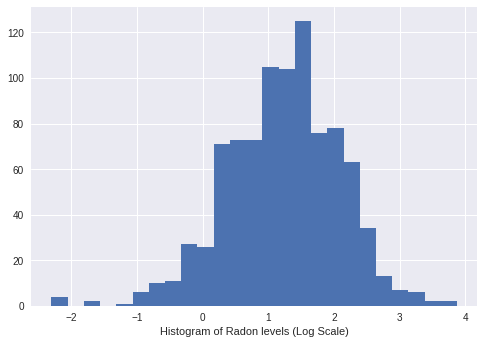

In [0]:
plt.hist(log_radon.numpy(), bins=25)
plt.xlabel("Histogram of Radon levels (Log Scale)")
plt.show()

## 4  Multilevel Modeling in TFP

### Conventional approaches

The two conventional alternatives to modeling radon exposure represent the two extremes of the bias-variance tradeoff:

**Complete Pooling:**

Treat all counties the same, and estimate a single radon level.
$$y_i = \beta_0 + \beta_1 x_i + \epsilon_i$$

**No Pooling:**

Model radon in each county independently.

$$y_i = \beta_{0,{j[i]}} + \beta_1 x_i + \epsilon_i$$
where $j = 1,\ldots,85$

The errors $\epsilon_i$ may represent measurement error, temporal within-house variation, or variation among houses.

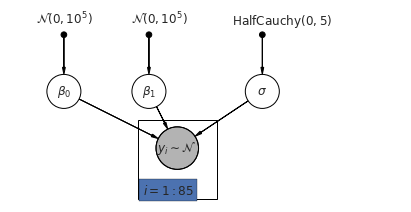

In [0]:
#@title 4.1 Complete Pooling Model
pgm = daft.PGM([7, 3.5], node_unit=1.2)
pgm.add_node(daft.Node("beta_0_prior", r"$\mathcal{N}(0, 10^5)$",
                       1, 3, fixed=True, offset=(0, 5)))
pgm.add_node(daft.Node("beta_1_prior", r"$\mathcal{N}(0, 10^5)$",
                       2.5, 3, fixed=True,
                       offset=(10, 5)))
pgm.add_node(daft.Node("sigma_prior", r"$\mathrm{HalfCauchy}(0, 5)$",
                       4.5, 3, fixed=True,
                       offset=(20, 5)))
pgm.add_node(daft.Node("beta_0", r"$\beta_0$",
                       1, 2))
pgm.add_node(daft.Node("beta_1", r"$\beta_1$",
                       2.5, 2))
pgm.add_node(daft.Node("sigma", r"$\sigma$",
                       4.5, 2))
pgm.add_node(daft.Node("y_i", r"$y_i \sim \mathcal{N}$",
                       3, 1, scale=1.25,
                       observed=True))
pgm.add_edge("beta_0_prior", "beta_0")
pgm.add_edge("beta_1_prior", "beta_1")
pgm.add_edge("sigma_prior", "sigma")
pgm.add_edge("sigma", "y_i")
pgm.add_edge("beta_0", "y_i")
pgm.add_edge("beta_1", "y_i")
pgm.add_plate(daft.Plate([2.3, 0.1,
                          1.4, 1.4], "$i = 1:85$"))

pgm.render()
plt.show()


Below, we fit the complete pooling model using Hamiltonian Monte Carlo.


In [0]:
@tf.function
def affine(x, kernel_diag, bias):
  """`diag(kernel_diag) @ x + bias` with broadcasting."""
  kernel_diag = kernel_diag[..., tf.newaxis]
  x = tf.ones_like(kernel_diag) * x
  return tf.linalg.matmul(kernel_diag, x)[..., 0, :] + bias

In [0]:
def pooled_model(floor):
  """Creates a joint distribution representing our generative process."""
  return tfd.JointDistributionSequential([
      tfd.Normal(loc=0., scale=1e5),                  # beta0
      tfd.Normal(loc=0., scale=1e5),                  # beta1
      tfd.HalfCauchy(loc=0., scale=5),                # sigma
      lambda s, b1, b0 : tfd.MultivariateNormalDiag(  # y
          loc=affine(floor[tf.newaxis],
                     b1[..., tf.newaxis],
                     b0[..., tf.newaxis]),
          scale_identity_multiplier=s
    )
  ])

@tf.function
def pooled_unnormalized_posterior_log_prob(beta0, beta1, sigma):
  """Computes `joint_log_prob` pinned at `log_radon`."""
  return pooled_model(floor).log_prob([beta0, beta1, sigma, log_radon])

In [0]:
@tf.function
def sample_pooled(num_chains, num_results, num_burnin_steps, num_observations):
  """Samples from the pooled model."""
  hmc = tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=pooled_unnormalized_posterior_log_prob,
      num_leapfrog_steps=10,
      step_size=0.005)

  initial_state = [
      tf.zeros([num_chains], name='init_beta0'),
      tf.zeros([num_chains], name='init_beta1'),
      tf.ones([num_chains], name='init_sigma')
  ]

  # Contrain `sigma` to the positive real axis. Other variables are
  # unconstrained.
  unconstraining_bijectors = [
      tfp.bijectors.Identity(),  # beta0
      tfp.bijectors.Identity(),  # beta1
      tfp.bijectors.Exp()        # sigma
  ]
  kernel = tfp.mcmc.TransformedTransitionKernel(
      inner_kernel=hmc, bijector=unconstraining_bijectors)

  samples, kernel_results = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=kernel)

  acceptance_probs = tf.reduce_mean(
      tf.cast(kernel_results.inner_results.is_accepted, tf.float32), axis=0)

  return samples, acceptance_probs

In [0]:
PooledModel = collections.namedtuple('PooledModel', ['beta0', 'beta1', 'sigma'])

samples, acceptance_probs = sample_pooled(
    num_chains=4,
    num_results=1000,
    num_burnin_steps=1000,
    num_observations=num_observations)

print('Acceptance Probabilities for each chain: ', acceptance_probs.numpy())
pooled_samples = PooledModel._make(samples)

for var, var_samples in pooled_samples._asdict().items():
  print('R-hat for ', var, ':',
        tfp.mcmc.potential_scale_reduction(var_samples).numpy())

Acceptance Probabilities for each chain:  [0.997 0.999 0.992 0.996]
R-hat for  beta0 : 1.0009435
R-hat for  beta1 : 1.0102544
R-hat for  sigma : 1.0009615


Plot the point estimates of the slope and intercept for the complete pooling model.

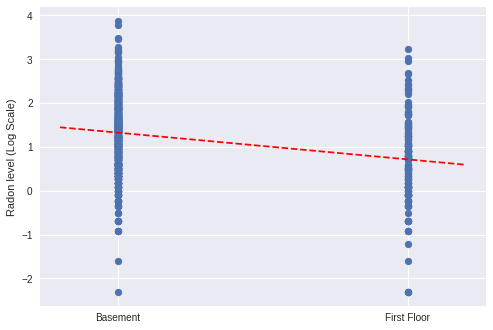

In [0]:
pooled_intercept = pooled_samples.beta0.numpy().mean()
pooled_slope = pooled_samples.beta1.numpy().mean()

plt.scatter(radon.floor, radon.log_radon)
xvals = np.linspace(-0.2, 1.2)
plt.ylabel('Radon level (Log Scale)')
plt.xticks([0, 1], ['Basement', 'First Floor'])
plt.plot(xvals, pooled_intercept + pooled_slope * xvals, 'r--');

In [0]:
#@title Utility function to plot traces of sampled variables.
def plot_traces(var_name, samples, num_chains):
  fig, axes = plt.subplots(1, 2, figsize=(14, 1.5), sharex='col', sharey='col')
  for chain in range(num_chains):
    axes[0].plot(samples[:, chain], alpha=0.7)
    axes[0].title.set_text("'{}' trace".format(var_name))
    sns.kdeplot(samples[:, chain], ax=axes[1], shade=False)
    axes[1].title.set_text("'{}' distribution".format(var_name))
    axes[0].set_xlabel('Iteration')
    axes[1].set_xlabel(var_name)
  plt.show()

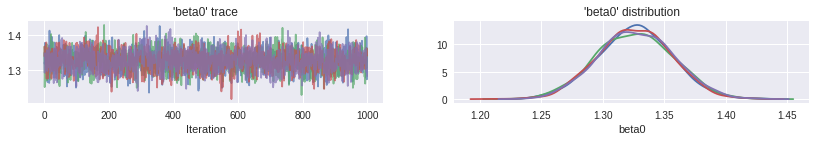

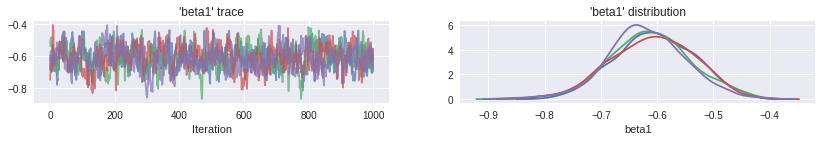

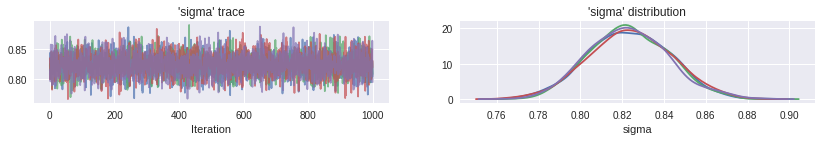

In [0]:
plot_traces(
    var_name='beta0', samples=pooled_samples.beta0.numpy(), num_chains=4)
plot_traces(
    var_name='beta1', samples=pooled_samples.beta1.numpy(), num_chains=4)
plot_traces(
    var_name='sigma', samples=pooled_samples.sigma.numpy(), num_chains=4)

Next, we estimate the radon levels for each county in the unpooled model.

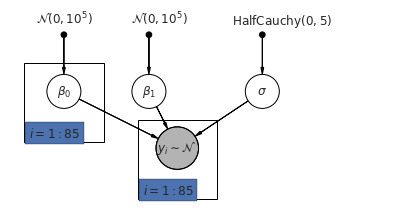

In [0]:
#@title 4.2 Unpooled Model { display-mode: "form" }
pgm = daft.PGM([7, 3.5], node_unit=1.2)
pgm.add_node(daft.Node("beta_0_prior",
                  r"$\mathcal{N}(0, 10^5)$",
                  1, 3, fixed=True,
                  offset=(0, 5)))
pgm.add_node(daft.Node("beta_1_prior",
                  r"$\mathcal{N}(0, 10^5)$",
                  2.5, 3, fixed=True,
                  offset=(10, 5)))
pgm.add_node(daft.Node("sigma_prior", r"$\mathrm{HalfCauchy}(0, 5)$",
                  4.5, 3, fixed=True,
                  offset=(20, 5)))
pgm.add_node(daft.Node("beta_0", r"$\beta_0$",
                  1, 2))
pgm.add_node(daft.Node("beta_1", r"$\beta_1$",
                  2.5, 2))
pgm.add_node(daft.Node("sigma", r"$\sigma$",
                  4.5, 2))
pgm.add_node(daft.Node("y_i", r"$y_i \sim \mathcal{N}$",
                       3, 1, scale=1.25,
                       observed=True))
pgm.add_edge("beta_0_prior", "beta_0")
pgm.add_edge("beta_1_prior", "beta_1")
pgm.add_edge("sigma_prior", "sigma")
pgm.add_edge("sigma", "y_i")
pgm.add_edge("beta_0", "y_i")
pgm.add_edge("beta_1", "y_i")
pgm.add_plate(daft.Plate([0.3, 1.1,
                    1.4, 1.4], "$i = 1:85$"))
pgm.add_plate(daft.Plate([2.3, 0.1,
                    1.4, 1.4], "$i = 1:85$"))

pgm.render()
plt.show()

In [0]:
def unpooled_model(floor, county):
  """Creates a joint distribution for the unpooled model."""
  return tfd.JointDistributionSequential([
      tfd.MultivariateNormalDiag(                    # beta0
          loc=tf.zeros([num_counties]), scale_identity_multiplier=1e5),
      tfd.Normal(loc=0., scale=1e5),                 # beta1
      tfd.HalfCauchy(loc=0., scale=5),               # sigma
      lambda s, b1, b0: tfd.MultivariateNormalDiag(  # y
          loc=affine(floor[tf.newaxis], b1[..., tf.newaxis],
                     tf.gather(b0, county, axis=-1)),
          scale_identity_multiplier=s)
  ])


@tf.function
def unpooled_unnormalized_posterior_log_prob(beta0, beta1, sigma):
  """Computes `joint_log_prob` pinned at `log_radon`."""
  return unpooled_model(floor,
                        county).log_prob([beta0, beta1, sigma, log_radon])

In [0]:
@tf.function
def sample_unpooled(num_chains, num_results, num_burnin_steps):
  """Samples from the unpooled model."""
  # Initialize the HMC transition kernel.
  hmc = tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=unpooled_unnormalized_posterior_log_prob,
      num_leapfrog_steps=10,
      step_size=0.025)

  initial_state = [
      tf.zeros([num_chains, num_counties], name='init_beta0'),
      tf.zeros([num_chains], name='init_beta1'),
      tf.ones([num_chains], name='init_sigma')
  ]
  # Contrain `sigma` to the positive real axis. Other variables are
  # unconstrained.
  unconstraining_bijectors = [
      tfp.bijectors.Identity(),  # beta0
      tfp.bijectors.Identity(),  # beta1
      tfp.bijectors.Exp()        # sigma
  ]
  kernel = tfp.mcmc.TransformedTransitionKernel(
      inner_kernel=hmc, bijector=unconstraining_bijectors)
  samples, kernel_results = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=kernel)

  acceptance_probs = tf.reduce_mean(
      tf.cast(kernel_results.inner_results.is_accepted, tf.float32), axis=0)

  return samples, acceptance_probs

In [0]:
UnpooledModel = collections.namedtuple('UnpooledModel',
                                       ['beta0', 'beta1', 'sigma'])

samples, acceptance_probs = sample_unpooled(
    num_chains=4, num_results=1000, num_burnin_steps=1000)

print('Acceptance Probabilities: ', acceptance_probs.numpy())
unpooled_samples = UnpooledModel._make(samples)

print('R-hat for beta1:',
      tfp.mcmc.potential_scale_reduction(unpooled_samples.beta1).numpy())
print('R-hat for sigma:',
      tfp.mcmc.potential_scale_reduction(unpooled_samples.sigma).numpy())

Acceptance Probabilities:  [0.882 0.884 0.896 0.9  ]
R-hat for beta1: 1.0041938
R-hat for sigma: 1.0027894


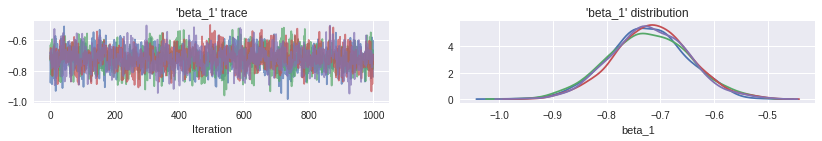

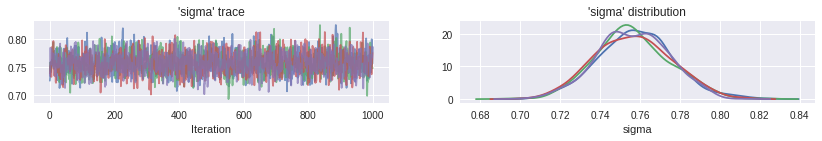

In [0]:
plot_traces(
    var_name='beta_1', samples=unpooled_samples.beta1.numpy(), num_chains=4)
plot_traces(
    var_name='sigma', samples=unpooled_samples.sigma.numpy(), num_chains=4)

Here are the unpooled county expected values for the intercept along with with 95% credible intervals for each chain. We also report R-hat value for each county's estimate.

In [0]:
#@title Utility function for Forest plots.
def forest_plot(num_chains, num_vars, var_name, var_labels, samples):
  fig, axes = plt.subplots(1, 2, figsize=(12, 15), sharey=True, gridspec_kw = {'width_ratios':[3, 1]})
  for var_idx in range(num_vars):
    values = samples[..., var_idx]
    rhat = tfp.mcmc.diagnostic.potential_scale_reduction(values).numpy()
    meds = np.median(values, axis=-2)
    los = np.percentile(values, 5, axis=-2)
    his = np.percentile(values, 95, axis=-2)

    for i in range(num_chains):
      height = 0.1 + 0.3 * var_idx + 0.05 * i
      axes[0].plot([los[i], his[i]], [height, height], 'C0-', lw=2, alpha=0.5)
      axes[0].plot([meds[i]], [height], 'C0o', ms=1.5)
    axes[1].plot([rhat], [height], 'C0o', ms=4)

  axes[0].set_xticks(np.arange(0, 4.5, 0.5))
  axes[0].set_yticks(np.arange(0.2, 26, 0.3))
  axes[0].set_ylim(0, 26)
  axes[0].grid(which='both')
  axes[0].invert_yaxis()
  axes[0].set_yticklabels(var_labels)
  axes[0].xaxis.set_label_position('top')
  axes[0].set(xlabel='95% Credible Intervals for {}'.format(var_name))

  axes[1].set_xticks([1, 2])
  axes[1].set_xlim(0.95, 2.05)
  axes[1].grid(which='both')
  axes[1].set(xlabel='R-hat')
  axes[1].xaxis.set_label_position('top')

  plt.show()


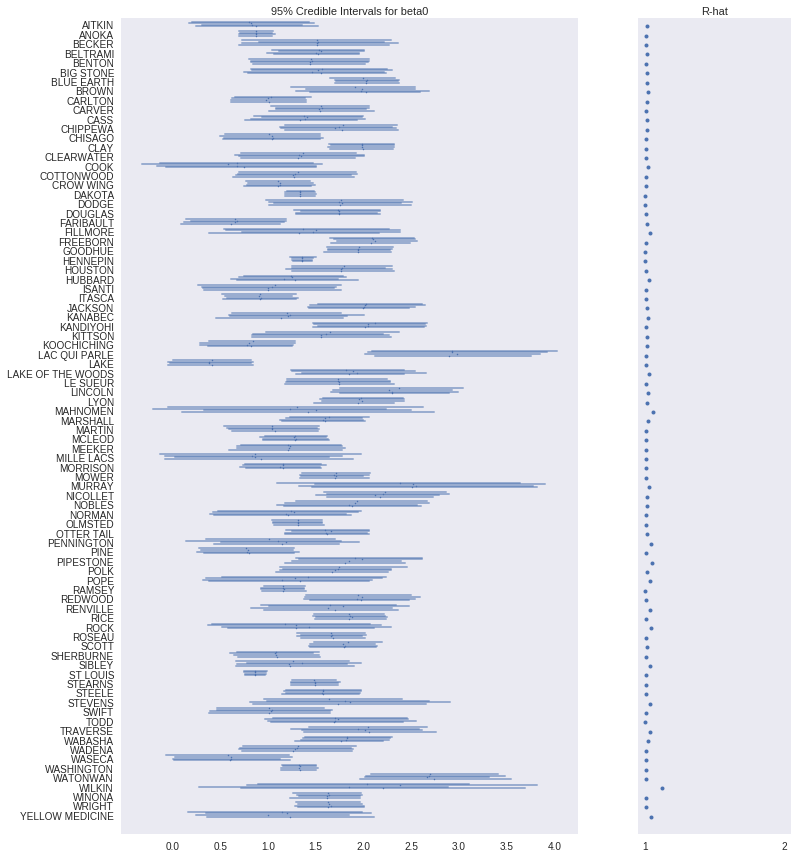

In [0]:
forest_plot(
    num_chains=4,
    num_vars=num_counties,
    var_name='beta0',
    var_labels=county_name,
    samples=unpooled_samples.beta0.numpy())

We can plot the ordered estimates to identify counties with high radon levels:

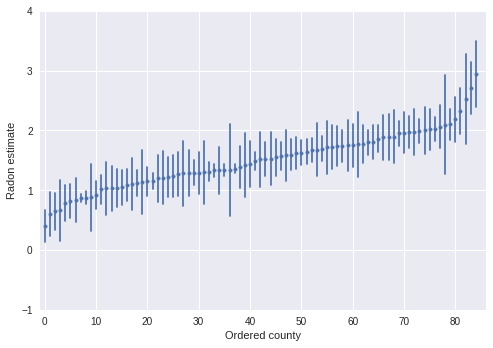

In [0]:
unpooled_intercepts_estimates = pd.Series(
    unpooled_samples.beta0.numpy().reshape(-1, num_counties).mean(axis=0),
    index=county_name)
unpooled_intercepts_se = pd.Series(
    unpooled_samples.beta0.numpy().reshape(-1, num_counties).std(axis=0),
    index=county_name)
unpooled_intercepts_order = unpooled_intercepts_estimates.sort_values().index

plt.scatter(
    range(num_counties),
    unpooled_intercepts_estimates[unpooled_intercepts_order],
    c='C0',
    marker='.')
for i, m, se in zip(
    range(num_counties),
    unpooled_intercepts_estimates[unpooled_intercepts_order],
    unpooled_intercepts_se[unpooled_intercepts_order]):
  plt.plot([i, i], [m - se, m + se], 'C0-')
plt.xlim(-1, num_counties + 1)
plt.ylim(-1, 4)
plt.xlabel('Ordered county')
plt.ylabel('Radon estimate')
plt.show()

In [0]:
#@title Utility function to plot estimated slopes and intercepts for a sample set of counties.
def plot_estimates(intercepts, slopes, sample_counties, secondary_intercepts=None, secondary_slopes=None):
  fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
  axes = axes.ravel()
  intercepts_indexed = pd.Series(intercepts, index=county_name)
  slopes_indexed = pd.Series(slopes, index=county_name)

  if secondary_intercepts is not None and secondary_slopes is not None:
    secondary_intercepts_indexed = pd.Series(secondary_intercepts, index=county_name)
    secondary_slopes_indexed = pd.Series(secondary_slopes, index=county_name)

  sample_county_codes = [county_name.index(c) for c in sample_counties]
  for i, c in enumerate(sample_county_codes):
    y = radon.log_radon[radon.county == c]
    x = radon.floor[radon.county == c]
    axes[i].scatter(x + np.random.randn(len(x)) * 0.01, y, alpha=0.4)

    # Plot both models and data
    xvals = np.linspace(-0.2, 1.2)
    axes[i].plot(xvals, intercepts_indexed[c] + slopes_indexed[c] * xvals)

    if secondary_intercepts is not None and secondary_slopes is not None:
      axes[i].plot(xvals, secondary_intercepts_indexed[c] + secondary_slopes_indexed[c] * xvals, 'r--')

    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['basement', 'floor'])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(sample_counties[i])
    if not i % 2:
      axes[i].set_ylabel('log radon level')

  plt.show()

Here are visual comparisons between the pooled and unpooled estimates for a subset of counties representing a range of sample sizes.

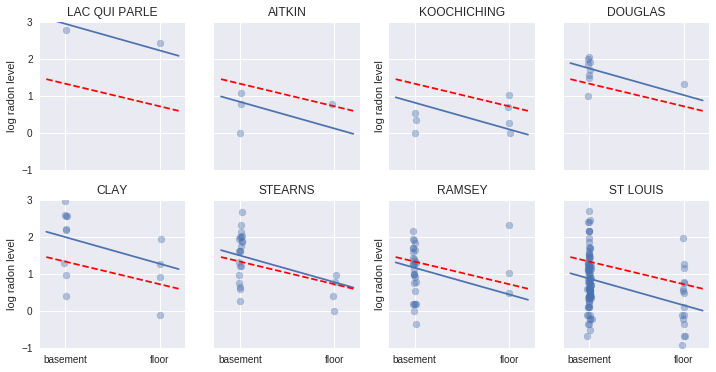

In [0]:
unpooled_intercepts = np.apply_over_axes(np.mean,
                                         unpooled_samples.beta0.numpy(),
                                         (0, 1)).flatten()
unpooled_slopes = unpooled_samples.beta1.numpy().mean()

sample_counties = ('LAC QUI PARLE', 'AITKIN', 'KOOCHICHING', 'DOUGLAS', 'CLAY',
                   'STEARNS', 'RAMSEY', 'ST LOUIS')

plot_estimates(
    intercepts=unpooled_intercepts,
    slopes=unpooled_slopes,
    sample_counties=sample_counties,
    secondary_intercepts=pooled_intercept,
    secondary_slopes=pooled_slope)

Neither of these models are satisfactory:

 * if we are trying to identify high-radon counties, pooling is useless
 * we do not trust extreme unpooled estimates produced by models using few observations


In the next installment, we will explore multilevel models to mitigate these problems by exploiting the natural hierarchical structure inherent in the problem. Stay tuned! 